# ARIMA Models

In our final time series notebook we introduce the ARIMA model. We'll be limiting ourselves to non-seasonal models, but if you are interested in seasonal data we will give you references to learn about the seasonal model. We also go through an example of implementing ARIMA on seasonal data in the Time Series HW.

## What You'll Learn

In particular this notebook goes over:
<ul>
    <li>Stationarity of time series data,</li>
    <li>Differencing methods,</li>
    <li>Autoregressive (AR) models,</li>
    <li>Moving Average (MA) models,</li>
    <li>AutoRegressive Integrated Moving Average (ARIMA) models.</li>
</ul>

As always we import the packages we'll use.

In [1]:
# import the packages we'll use
from datetime import datetime

## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")

## Stationarity

<i>Stationarity</i> is a property of time series data. In a nutshell it means that the statistical properties are constant over time. For example if we let $y|t$ be the value of our target at time $t$ stationarity implies:
$$
\begin{array}{l l}
E(y|t) = \mu, & \text{ some constant independent of } t\\
\text{cov}\left(y|t, y|s\right) = C(|t-s|), & \text{ is a function that only depends on the time between } s \text { and } t.
\end{array}
$$

This automatically rules out seasonal and trending time series. 


Let's examine this plot and try to identify stationary time series.

In [2]:
# loading and preparing data
livestock = pd.read_csv("livestock.csv", parse_dates = ['year'])
goog = pd.read_csv("goog.csv")
gasoline = pd.read_csv("gasoline_2013.csv")
measles = pd.read_csv("measles.csv",parse_dates = ['month'])
elec = pd.read_csv("elec.csv",parse_dates = ['month'])
marathon = pd.read_csv("marathon.csv",parse_dates = ['year'])
lynx = pd.read_csv("lynx.csv",parse_dates = ['year'])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


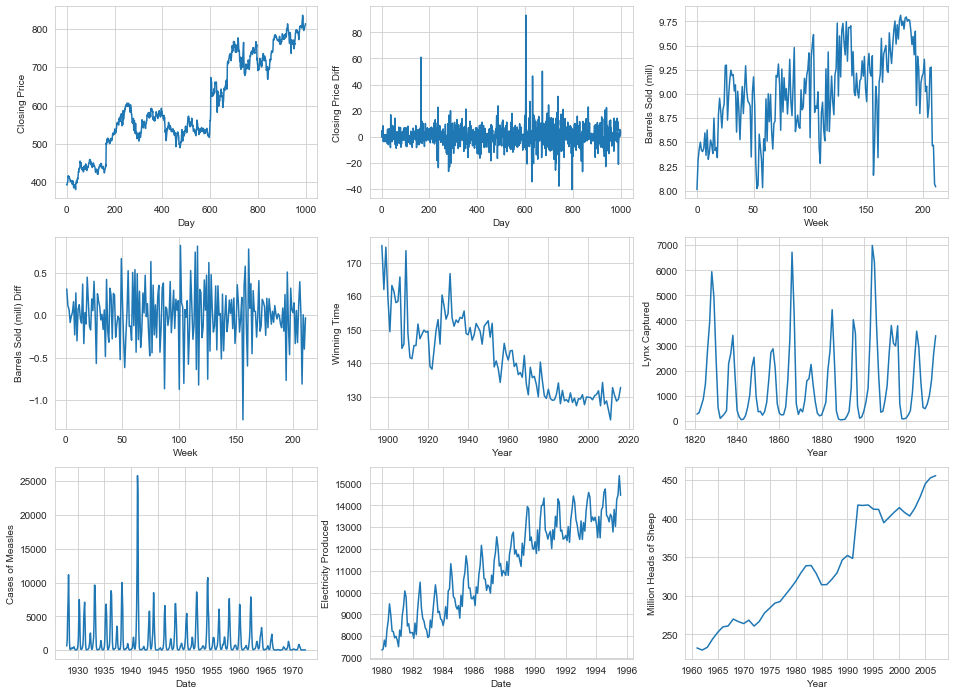

In [3]:
fig,ax = plt.subplots(3,3,figsize=(16,12))

ax[0,0].plot(goog.closing_price)
ax[0,0].set_xlabel("Day")
ax[0,0].set_ylabel("Closing Price")

ax[0,1].plot(goog.closing_price.diff())
ax[0,1].set_xlabel("Day")
ax[0,1].set_ylabel("Closing Price Diff")

ax[0,2].plot(gasoline.barrels_m)
ax[0,2].set_xlabel("Week")
ax[0,2].set_ylabel("Barrels Sold (mill)")

ax[1,0].plot(gasoline.barrels_m.diff())
ax[1,0].set_xlabel("Week")
ax[1,0].set_ylabel("Barrels Sold (mill) Diff")

ax[1,1].plot(marathon.year,marathon.time)
ax[1,1].set_xlabel("Year")
ax[1,1].set_ylabel("Winning Time")

ax[1,2].plot(lynx.year,lynx.captured)
ax[1,2].set_xlabel("Year")
ax[1,2].set_ylabel("Lynx Captured")

ax[2,0].plot(measles.month,measles.cases)
ax[2,0].set_xlabel("Date")
ax[2,0].set_ylabel("Cases of Measles")

ax[2,1].plot(elec.month,elec['production'])
ax[2,1].set_xlabel("Date")
ax[2,1].set_ylabel("Electricity Produced")

ax[2,2].plot(livestock.year,livestock.million_head)
ax[2,2].set_xlabel("Year")
ax[2,2].set_ylabel("Million Heads of Sheep")

plt.show()

Looking at the data we can rule out any data with a trend, or seasonality.

There are three plots that display a stationary time series. The two Diff plots, created by taking the pairwise differences of time series (more on this soon), and the plot of lynx captures in the second row of plots. 

The first two have no clear pattern, trend, or seasonality. The lynx plot may look seasonal at a glance, but upon closer inspection the cycles that are present are not at regular intervals, meaning the data is not seasonal. 


### Making a Time Series Stationary

It is often desirable to take a non-stationary time series, for example the Google closing price data, and transform it into one that is stationary, like the Google differences data. 

#### Differencing

As we've alluded to a main technique in creating stationary series is differencing. Take the time series, $y_t$, with $T$ observations and use it to create a new series like so:
$$
y_t - y_{t-1} = y_t'
$$

`pandas` has a great method for making the differenced time series, `.diff()`.

In [4]:
## We'll get the differenced series here

# diff computes row-wise differences
goog.diff().head()

,closing_price
0,NaN
1,-0.317932
2,4.793823
3,0.705414
4,2.478882


Note that this new series, $y_t'$ only has $T-1$ observations.

##### Checking with ACF Plots

We can check to see how the trend and seasonality were affected by making some ACF plots.

Below we'll plot the Google data plot in blue, and the differenced plot in red on top of the blue.

In [5]:
## Bring back functions from notebook 2


def make_lag_df(df,feature,lag):
    lag_df = df.copy()
    lag_df[feature+"_lag"] = np.nan
    
    lag_df.loc[lag:,feature+"_lag"] = lag_df.loc[0:len(lag_df)-(lag+1),feature].values
    
    return lag_df


def get_autocorr(df,feature,lag):
    df = make_lag_df(df,feature,lag)
    mean_y = df[feature].mean()
    
    y_ts = df[feature].values
    y_lags = df.dropna()[feature+"_lag"].values
    
    numerator = np.sum((y_ts[lag:] - mean_y)*(y_lags - mean_y))
    denom = np.sum(np.power(y_ts - mean_y,2))
    
    return numerator/denom

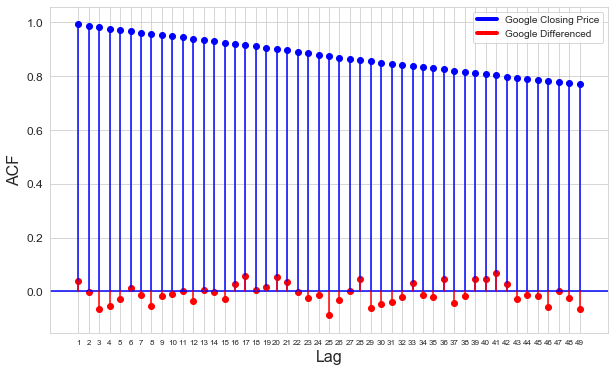

In [7]:
## Plotting block
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="blue", lw=4),
                Line2D([0], [0], color="red", lw=4)]






### Google Data
# we'll go up to 50 lag
n=50

# this stores the autocorrelations for the 
# google data
goog_autos = []

# get the autocorr.
for i in range(1,n,1):
    goog_autos.append(get_autocorr(goog,'closing_price',i))

# make a figure
plt.figure(figsize=(10,6))

# plot a horizontal line
plt.axhline(y=0, xmin=0, xmax=n, color = "blue")

# plot each autocorrelation against the lag
plt.scatter(range(1,n,1), 
           goog_autos,
           c='b')

# Plot vertical lines
for i in range(1,n,1):
    plt.plot(i*np.ones(2),[0,goog_autos[i-1]],'b')

# Add labels
plt.xlabel("Lag", fontsize=16)
plt.ylabel("ACF", fontsize=16)

# set tick marks
plt.xticks(np.arange(1,n,1), fontsize=8)
plt.yticks(fontsize=12)


### Google Diff Data
goog_diff_autos = []

# get the autocorr for the diff data
# this creates the differences
# then drops the nas
# then resets our index 
# we'll only use it for the autocorr calcs
diff_data = goog.diff().dropna().reset_index(drop=True)

for i in range(1,n,1):
    goog_diff_autos.append(get_autocorr(diff_data,'closing_price',i))

# plot each autocorrelation against the lag
plt.scatter(range(1,n,1), 
           goog_diff_autos,
           c='r')

# Plot vertical lines
for i in range(1,n,1):
    plt.plot(i*np.ones(2),[0,goog_diff_autos[i-1]],'r')
    
plt.legend(custom_lines, ['Google Closing Price', 'Google Differenced'])

plt.show()

Notice the huge difference?

Our differenced data has negligible autocorrelations, indicating no seasonality or trends.

#### Second, Third, Fourth Difference and More

Sometimes differencing isn't enough and you'll want to do it again. 

Occasionally the differenced data will not appear to be stationary and it may be necessary to difference the data a second time to obtain a stationary series.

Let $y_t'$ be the differenced series. Then the second differenced series can be obtained like so:
$$
y_t' - y_{t-1}' = y_{t}'',
$$
or
$$
(y_t - y_{t-1}) - (y_{t-1} - y_{t-2}) = y_t - 2y_{t-1} - y_{t-2} = y_t''
$$

Which now has $T-2$ observations.

In [8]:
goog.diff().diff().head()

,closing_price
0,NaN
1,NaN
2,5.111755
3,-4.088409
4,1.773468


You can continue in this way a third, fourth, fifth time or even more. Just be careful you aren't throwing away too much data in the process.

##### Random Walk Models

Consider again our single differences, $y_t - y_{t-1}$. Sometimes this difference can be modeled as draws from some random distribution. When this is the case we can denote the difference as $\epsilon_t$,
$$
y_t - y_{t-1} = \epsilon_t.
$$

We can then use this to derive a model for $y_t$ called a random walk model:
$$
y_t = y_{t-1} + \epsilon_t.
$$

It's called a random walk because our next position is determined by our current position plus a random step. 

From <a href = "https://otexts.com/fpp2/stationarity.html">Forecasting: Principles and Practice</a>:
<q>
    Random walk models are widely used for non-stationary data, particularly financial and economic data.
</q>

These models should look quite familiar, think of the na\&iuml;ve method from Notebook 1.

## Practice

You'll learn about the seasonal differencing technique using the measles data.

In [9]:
# create the pre 1963 measles data here
# you don't need to load in the data
# we've done that above and stored it in
# measles
measles_1963 = measles.loc[measles.month < datetime(1963,1,1),]


One way to perform differencing with seasonal data is to subtract off the corresponding observation from the previous season. 

So for example if a season is completed every $5$ time steps, then the differencing would be:
$$
y_t - y_{t-5} = y_t'.
$$

In general if a season is completed every $m$ time steps, then the differencing would be:
$$
y_t - y_{t-m} = y_t'
$$.

Recall that for the measles data, a season lasts $2$ years or $24$ months. Perform seasonal differencing on the pre 1963 measles data and plot it.

Hint: here is the documentation for `.diff()`, <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.diff.html">https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.diff.html</a>.

In [16]:
## Code Here

measles['diff'] = measles_1963['cases'].diff(periods=24)

In [17]:
measles

,month,cases,diff
0,1928-01-01,609,NaN
1,1928-02-01,1516,NaN
2,1928-03-01,4952,NaN
3,1928-04-01,7466,NaN
4,1928-05-01,11155,NaN
...,...,...,...
529,1972-02-01,35,NaN
530,1972-03-01,40,NaN
531,1972-04-01,31,NaN
532,1972-05-01,41,NaN


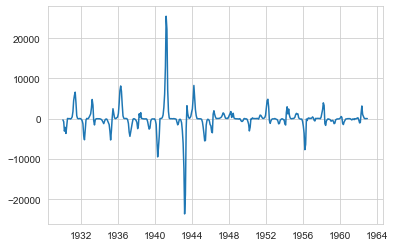

In [19]:
## Code Here


plt.plot(measles['month'].iloc[24:], measles['diff'].iloc[24:])





In [22]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(measles['diff'].dropna().to_numpy())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.306399
p-value: 0.000000
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571


We now introduce the two parts of an ARIMA Model before fitting one ourselves.

## Autoregressive (AR) Models

The AR in ARIMA comes from Autoregressive.

This word should seem somewhat familiar, especially the regress part. Remember a regression model was one that used other features, $X$, to predict the target, $y$. In autoregressive models you regress the target on past observations of itself.

An autoregressive model of order $p$, referred to as AR(p), takes the form:
$$
y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \dots + \phi_p y_{t-p} + \epsilon_t, 
$$
where $\epsilon_t$ is a random noise term.

If:
<ul>
    <li>$\phi_i = 0$ for all $i$ you have what is known as <i>white noise,</i></li>
    <li>$\phi_1 = 1$ and $c=0,\phi_i=0$ for all $i\neq 1$ you have the random walk model,</li>
    <li>$\phi_1 = 1$, $c\neq0$, and $\phi_i=0$ for all $i\neq1$ you have the random walk with drift model.</li>
</ul>

We typically assume that the time series we're modeling with an AR model is stationary (which is why we introduced it above). This introduces restrictions on the parameters for AR models of any order. In particular for:
<ul>
    <li>AR(1), $-1 < \phi_1 < 1$,</li>
    <li>AR(2), $-1 < \phi_2 < 1, \ \phi_1 + \phi_2 < 1, \ \phi_2 - \phi_1 < 1$.</li>
</ul>

We won't need to worry too much about the restrictions since we won't be coding by hand. The `statsmodels` package will handle them for us.

## Moving Average (MA) Models

The MA in ARIMA comes from Moving Average.

Moving average models are of a similar flavor to AR models, we still regress $y_t$ on past values, but this time not past values of the target data but past values of the forecast error. 

Here we present an order $q$ or MA($q$) model:
$$
y_t = c + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \dots + \theta_q \epsilon_{t-q},
$$
where $\epsilon_t$ is random noise.

As with AR models we want stationarity which imposes restrictions on the $\theta$s, for:
<ul>
    <li>MA(1), $-1 < \theta_1 < 1$,</li>
    <li>MA(2), $-1 < \theta_2 < 1, \ \theta_1 + \theta_2 > -1, \ \theta_2 - \theta_1 < 1$.</li>
</ul>
For higher order models there are more complex restrictions, but again `statsmodels` will handle those for us.

We're now ready to Learn ARIMA.

## Non-Seasonal AutoRegressive Integrated Moving Average (ARIMA) Models

Now we put differencing, AutoRegressive models, and Moving Average Models together.

Let $y_t$ be the original time series and $y_t'$ be a differenced version of the time series in which we have performed first differencing $d$ times. Then an ARIMA($p,d,q$) model is:
$$
y_t' = c + \phi_1 y_{t-1}' + \dots + \phi_p y_{t-p}' + \theta_1 \epsilon_{t-1} + \dots + \theta_q \epsilon_{t-q} + \epsilon_t.
$$

Some special versions of the ARIMA model are listed below:
$$
\begin{array}{l l}
    \text{White Noise} & \text{ARIMA}(0,0,0),\\
    \text{Random Walk} & \text{ARIMA}(0,1,0) \text{ with no constant},\\
    \text{Random Walk with Drift} & \text{ARIMA}(0,1,0) \text{ with a constant},\\
    \text{AR}(p) & \text{ARIMA}(p,0,0),\\
    \text{MA}(q) & \text{ARIMA}(0,0,q).
\end{array}
$$

We'll now use `statsmodels` to fit and forecast the lynx data with an ARIMA model.

In [23]:
lynx_train = lynx.loc[lynx.year < datetime(1925,1,1),].copy()
lynx_test = lynx.drop(lynx_train.index).copy()

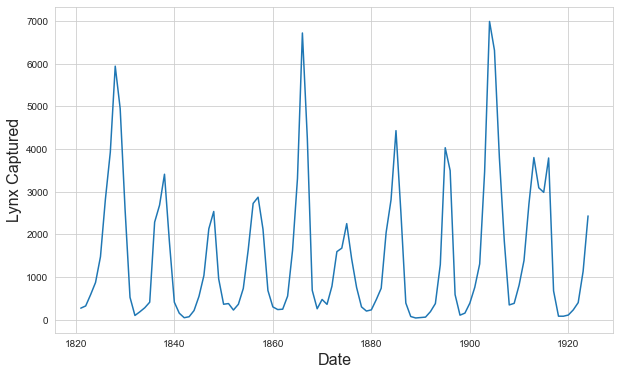

In [24]:
plt.figure(figsize=(10,6))

plt.plot(lynx_train.year, lynx_train.captured)

plt.xlabel("Date", fontsize=16)
plt.ylabel("Lynx Captured", fontsize=16)

plt.show()

In [25]:
# Import the ARIMA object
from statsmodels.tsa.api import ARIMA

In [31]:
# First put in the training values
# then enter the order as (p,d,q)
arima = ARIMA(lynx_train.captured.values, order = (4,0,3))

In [32]:
# Fit the model
arima_fit = arima.fit()

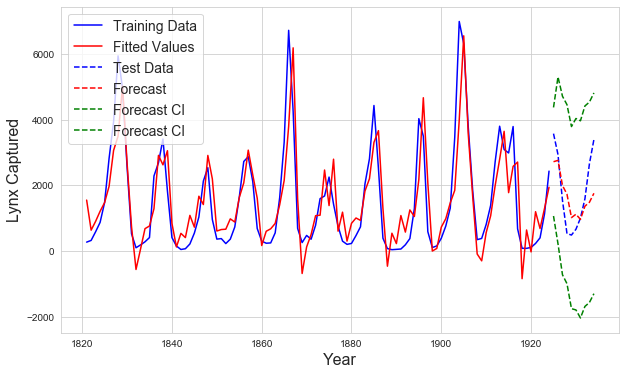

In [33]:
# plot the forecast
plt.figure(figsize=(10,6))

# the training data and fitted values
plt.plot(lynx_train.year, lynx_train.captured,
             'b', label = "Training Data")
plt.plot(lynx_train.year,arima_fit.fittedvalues,
             'r', label = "Fitted Values")

# The test data and forecast
plt.plot(lynx_test.year,lynx_test.captured,
             'b--', label="Test Data")
plt.plot(lynx_test.year,arima_fit.forecast(len(lynx_test.captured))[0],
             'r--', label = "Forecast")

plt.plot(lynx_test.year,arima_fit.forecast(len(lynx_test.captured))[2],
             'g--', label = "Forecast CI")

plt.xlabel("Year", fontsize = 16)
plt.ylabel("Lynx Captured", fontsize = 16)

plt.legend(fontsize=14)

plt.show()

I chose $d=0$ because as we stated above the lynx data was already stationary. I chose $p=q=1$ because I just wanted to demonstrate the process of fitting the model. It is possible to get a better fit to the test data. For example try $p=4$ and $q=3$.

A quick note about the `forecast()` output. Notice how unlike the exponential smoothing code I had `[0]` after `forecast()`. This is because the `.fit()` method returns an `ARIMAResults` object. When you use the `forecast()` method for this object it returns three outputs, the forecasts stored in position `0`, the standard errors on those forecasts in position `1`, and a confidence interval around your forecast in `2`. The confidence interval is similar to what we produced for the regression line in Regression Notebook 2.

## Practice

Now you go ahead and implement an ARIMA model on the Google Closing Price data.

In [40]:
## Code Here
goog['diff'] = goog['closing_price'].diff()
goog.head()
# print(len(goog))

,closing_price,diff
0,392.830017,NaN
1,392.512085,-0.317932
2,397.305908,4.793823
3,398.011322,0.705414
4,400.490204,2.478882


In [42]:
cut = 900

In [81]:
## Code Here
arima = ARIMA(goog['closing_price'].iloc[:cut].to_numpy(), order = (3,0,4))

arima_fit = arima.fit()

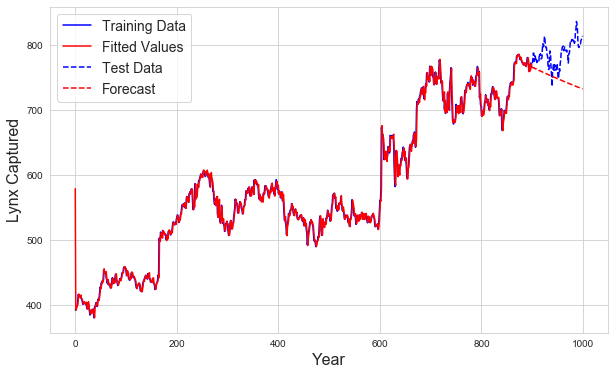

In [85]:

# plot the forecast
plt.figure(figsize=(10,6))

# the training data and fitted values
plt.plot(goog.iloc[:cut].index, goog['closing_price'].iloc[:cut],
             'b', label = "Training Data")
plt.plot(goog.iloc[:cut].index,arima_fit.fittedvalues,
             'r', label = "Fitted Values")

# The test data and forecast
plt.plot(goog.iloc[cut:].index,goog['closing_price'].iloc[cut:],
             'b--', label="Test Data")
plt.plot(goog.iloc[cut:].index,arima_fit.forecast(1000-cut)[0],
             'r--', label = "Forecast")

### Here is the example by kcroxall 
# plt.plot(goog_train.index, goog_train.closing_price,'b', label = "Training Data")
# plt.plot(goog_train.index[1:],arima_fit.fittedvalues + goog_train.closing_price[:-1],'r', label = "Fitted Values")

# plt.plot(lynx_test.year,arima_fit.forecast(len(lynx_test.captured))[2],
#              'g--', label = "Forecast CI")

plt.xlabel("Year", fontsize = 16)
plt.ylabel("Lynx Captured", fontsize = 16)

plt.legend(fontsize=14)

plt.show()

That's it for this notebook and for Time Series in general.

We didn't dive nearly as far into the time series theory as we did for regression. That's okay these notebooks were supposed to introduce you to the topic and get you familiar with implementing the algorithms we've presented in python.

To learn more flip through <a href="https://otexts.com/fpp2/">Forecasting: Principles and Practice</a>, by Rob J Hyndman and George Athanasopoulos, or look through other texts and papers on this subject.

There's also some additional material in the Time Series HW that you can work through.

Next up Classification!

## References

Sections 8.1 to 8.5 of <a href="https://otexts.com/fpp2/">Forecasting: Principles and Practice</a>, by Rob J Hyndman and George Athanasopoulos.

The time series section of the `statsmodels` documentation, <a href="https://www.statsmodels.org/stable/tsa.html">https://www.statsmodels.org/stable/tsa.html</a>.